## Init

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch. cuda.is_available() else "cpu"
NUM_EPOCHS = 24
BATCH_SIZE = 32
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
PIN_MEMORY = True
PATH_TO_FOLDER = ""     # input folder PATH for training
TRAIN_IMG_DIR = f"{PATH_TO_FOLDER}eyeglasses_dataset/train/images/"
TRAIN_MASK_DIR = f"{PATH_TO_FOLDER}eyeglasses_dataset/train/masks/"
VAL_IMG_DIR = f"{PATH_TO_FOLDER}eyeglasses_dataset/val/images/"
VAL_MASK_DIR = f"{PATH_TO_FOLDER}eyeglasses_dataset/val/masks/"
TEST_IMG_DIR = f"{PATH_TO_FOLDER}eyeglasses_dataset/test/images/"
TEST_MASK_DIR = f"{PATH_TO_FOLDER}eyeglasses_dataset/test/masks/"

I recreated the U-Net model, a popular architecture for image segmentation tasks. U-Net is favored for its symmetric design, comprising a contracting path to capture context and an expansive path for precise localization. This architecture is widely used due to its effectiveness in biomedical image segmentation and its ability to achieve high accuracy with relatively small datasets. <br>
Some required functions are in ```utils.py```

<img src="image.png" width="600">

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False), # Because will use BatchNorm
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False), # Because will use BatchNorm
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [4]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(
                DoubleConv(in_channels=in_channels, out_channels=feature)
            )
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    in_channels=feature*2,
                    out_channels=feature,
                    kernel_size=2,
                    stride=2
                )
            )
            self.ups.append(
                DoubleConv(in_channels=feature*2, out_channels=feature)
            )

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

Resize all images to 256*256 pixels. <br> For training flip and rotate some of them.

In [5]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=30, p=0.5),
        A.HorizontalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [6]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [7]:
from utils import get_loaders

train_loader, val_loader, test_loader = get_loaders(
    TEST_IMG_DIR,
    TEST_MASK_DIR,
    val_transform,
    train_transform,
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
)

In [8]:
def train_fn(loader, model, optimizer, loss_fn, scaler, epoch, device):
    loop = tqdm(loader)
    total_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.float().unsqueeze(dim=1).to(device)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate loss
        total_loss += loss.item()

        # update tqdm loop
        loop.set_postfix(epoch=epoch+1, loss=loss.item())

    return total_loss/len(loader)

Use the scheduler to decrease the learning rate by 2 every 7 epochs to achieve higher metrics. <br>
Every epoch save predictions of test images to keep track of model improvments visually.

In [ ]:
from utils import save_checkpoint, check_metrics, save_predictions_as_images

train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_dices = []
val_ious = []

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
scaler = torch.cuda.amp.GradScaler()
for epoch in range(NUM_EPOCHS):
    pred_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler, epoch, device=DEVICE)
    train_losses.append(pred_loss)

    # save the model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, filename=f"checkpoint_{epoch+1}.pth.tar")

    # calculate metrics
    val_acc, val_loss, val_precision, val_recall, val_dice, val_iou = check_metrics(val_loader, model, loss_fn, device=DEVICE)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_dices.append(val_dice)
    val_ious.append(val_iou)

    # print some examples to a folder
    save_predictions_as_images(
        test_loader, model, device=DEVICE, folder=f"test_images_{epoch+1}/", orig_img=True
    )

    scheduler.step()

Here is a part of thaining loop <br>
<img src="training_loop.png" width="600">

In [ ]:
# saving metrics
data = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "val_precisions": val_precisions,
    "val_recalls": val_recalls,
    "val_dices": val_dices,
    "val_ious": val_ious,
}

with open('all_data.pkl', 'wb') as f:
    pickle.dump(data, f)

## Evaluating metrics

Metrics demonstrate that model has high accuracy, precision, recall, Dice coefficient, and IoU. The metrics improve rapidly in the initial epochs and stabilize, indicating effective learning and generalization. The model shows very good capability in accurately segmenting images, making it reliable for practical use.

In [7]:
# loading metrics
with open('all_data.pkl', 'rb') as f:
    data = pickle.load(f)

train_losses = data["train_losses"]
val_losses = data["val_losses"]
val_accuracies = data["val_accuracies"]
val_precisions = data["val_precisions"]
val_recalls = data["val_recalls"]
val_dices = data["val_dices"]
val_ious = data["val_ious"]

In [8]:
metrics = {
    "Val accuracies": val_accuracies[-1]/100,
    "Val precisions": val_precisions[-1],
    "Val recalls": val_recalls[-1],
    "Val dices": val_dices[-1],
    "Val ious": val_ious[-1]
}

for keys,values in metrics.items():
    print(f"{keys}: {values*100:.2f}%")

Val accuracies: 99.65%
Val precisions: 95.16%
Val recalls: 94.18%
Val dices: 94.67%
Val ious: 89.88%


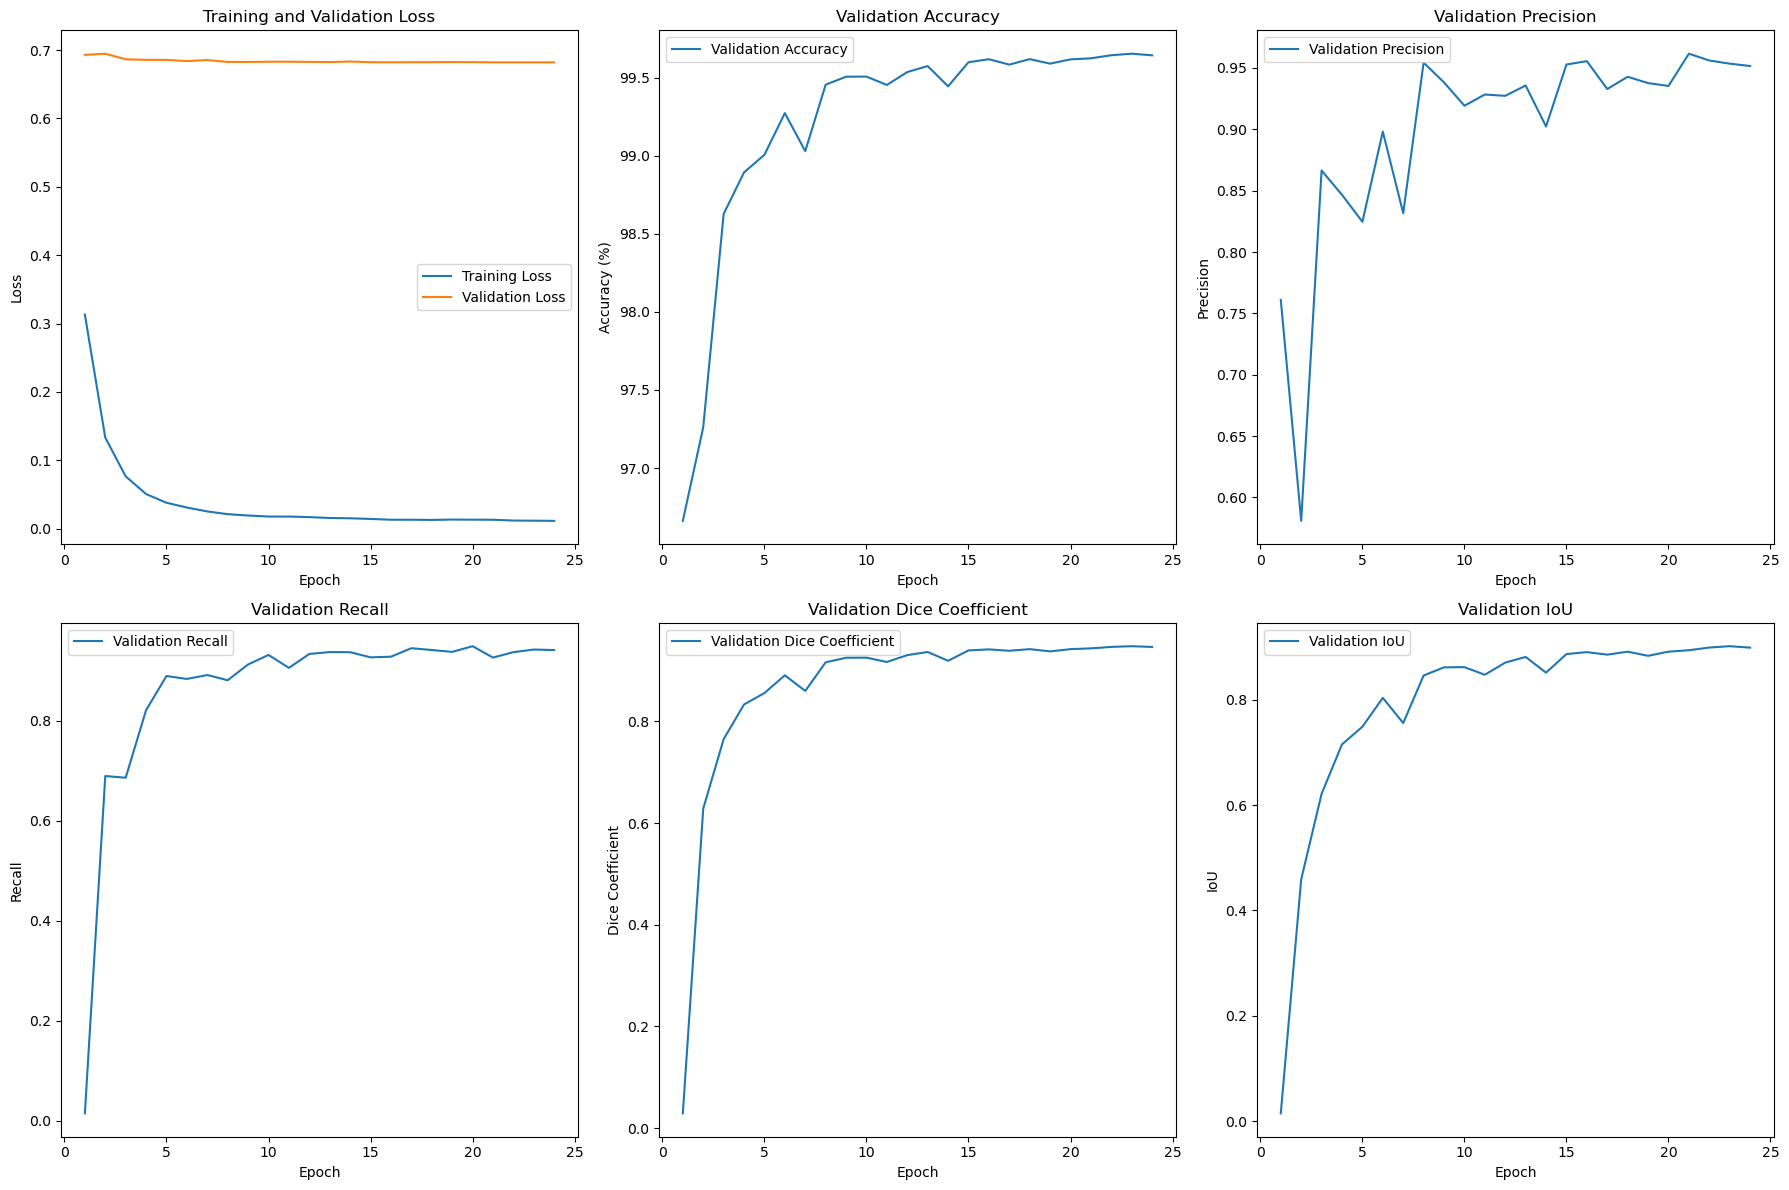

In [9]:
### Plotting and saving the plots to files
epochs = list(range(1, NUM_EPOCHS + 1))

plt.figure(figsize=(18, 12))

# Plotting training and validation losses
plt.subplot(2, 3, 1)
sns.lineplot(x=epochs, y=train_losses, label='Training Loss')
sns.lineplot(x=epochs, y=val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting validation accuracies
plt.subplot(2, 3, 2)
sns.lineplot(x=epochs, y=val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

# Plotting validation precisions
plt.subplot(2, 3, 3)
sns.lineplot(x=epochs, y=val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Validation Precision')
plt.legend()

# Plotting validation recalls
plt.subplot(2, 3, 4)
sns.lineplot(x=epochs, y=val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Validation Recall')
plt.legend()

# Plotting validation dice coefficients
plt.subplot(2, 3, 5)
sns.lineplot(x=epochs, y=val_dices, label='Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Validation Dice Coefficient')
plt.legend()

# Plotting validation IoUs
plt.subplot(2, 3, 6)
sns.lineplot(x=epochs, y=val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Validation IoU')
plt.legend()

plt.tight_layout()
plt.show()


## Testing

### Loading model and calculate metrics

```TEST_IMG_DIR``` - PATH to images directory <br>
```TEST_MASK_DIR``` - PATH to image's masks directory (if available input for calculating metrics) <br>

For testing run ```Init``` section and after the you can run this section

In [10]:
TEST_IMG_DIR = "eyeglasses_dataset/test/images/"
TEST_MASK_DIR = "eyeglasses_dataset/test/masks/"
ORIG_IMAGE = True

if not os.path.exists(TEST_MASK_DIR):
    TEST_MASK_DIR = None
    ORIG_IMAGE = False
    

At a cell below we are loading a model. It is compatible with CPU and GPU <br>
If you have mask directory code will calculate metrics

In [11]:
from utils import load_checkpoint, get_loaders, get_test_loader, check_metrics, save_predictions_as_images

DEVICE = "cuda" if torch. cuda.is_available() else "cpu"
load_checkpoint("checkpoint_24.pth.tar", model=model, device=DEVICE)

if TEST_MASK_DIR is not None:
    test_loader = get_loaders(test_dir=TEST_IMG_DIR, test_mask_dir=TEST_MASK_DIR, val_transform=val_transform, testing=True)
    accuracy, avg_loss, avg_precision, avg_recall, avg_dice, avg_iou = check_metrics(test_loader, model, loss_fn, device=DEVICE)

    metrics = {
        "Avg Precision": avg_precision,
        "Avg Recall": avg_recall,
        "Avg Dice Score": avg_dice,
        "Avg IoU": avg_iou,
    }

    for keys,values in metrics.items():
        print(f"{keys}: {values*100:.2f}%")
else:
    test_loader = get_test_loader(TEST_IMG_DIR, val_transform)

Acc: 99.65%
Avg Precision: 94.24%
Avg Recall: 93.52%
Avg Dice Score: 93.85%
Avg IoU: 88.48%


### Evaluating and plotting predictions

In this picture you can see predictions(white color) overlaid on top of original images. <br>
You can change number of samples by changing argument ```num_samples```

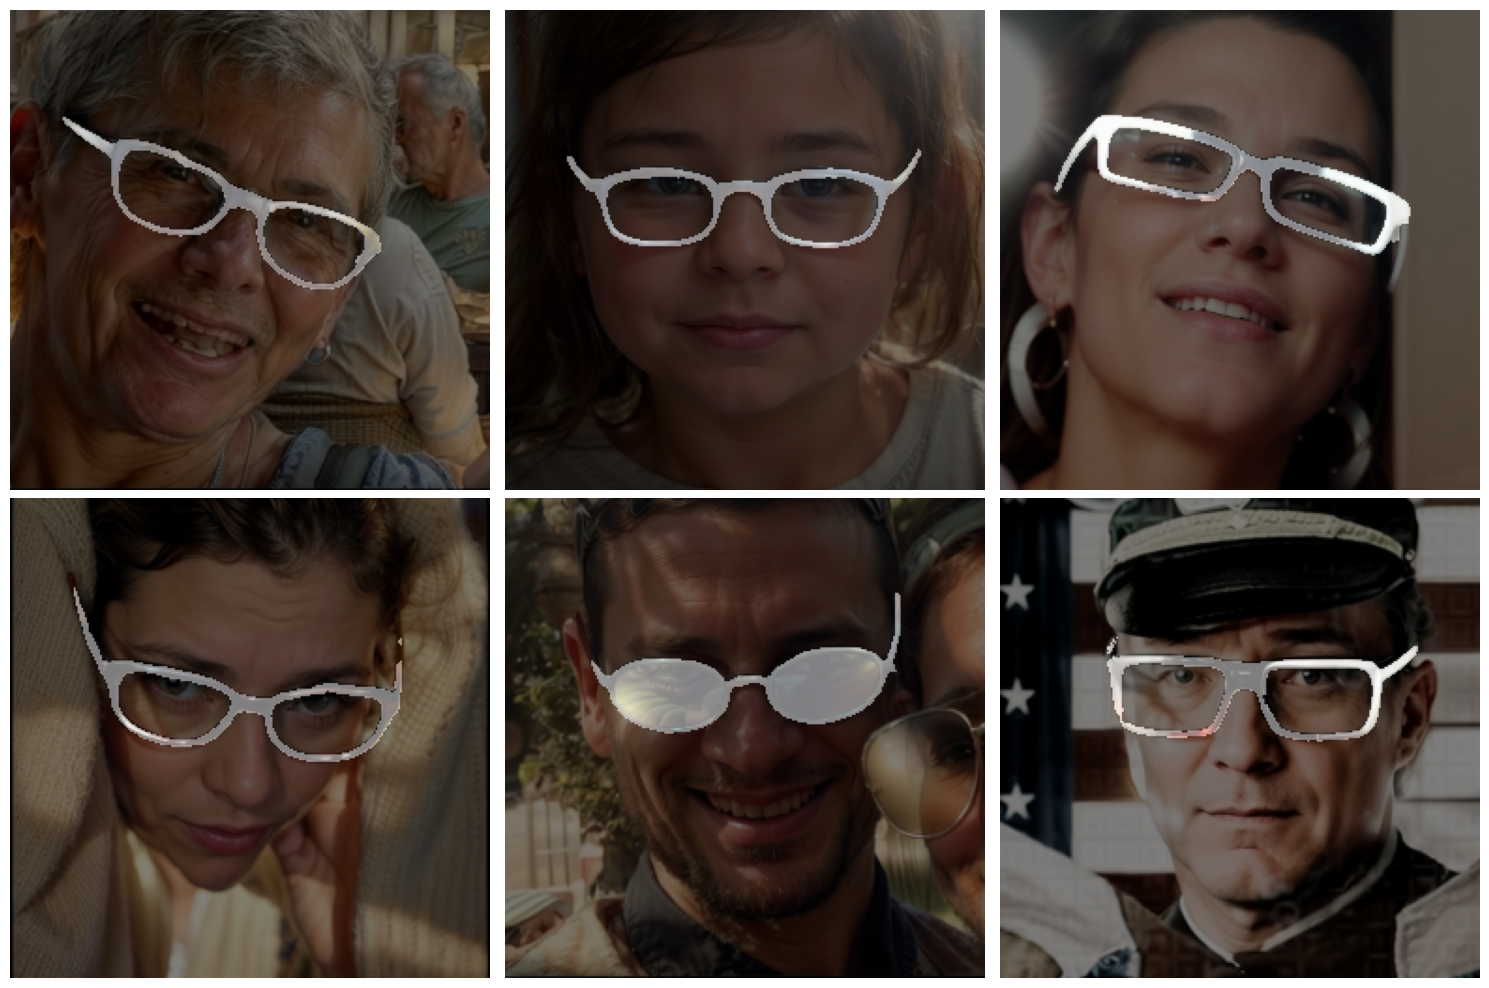

In [14]:
from utils import plot_random_samples

plot_random_samples(test_loader, model, device=DEVICE, num_samples=6)

### Saving predictions

There is 2 options:
1. Original image -> Mask from given folder -> Prediction.
   <br> For that you need to specify mask folder at the beginning of Testing section <br>
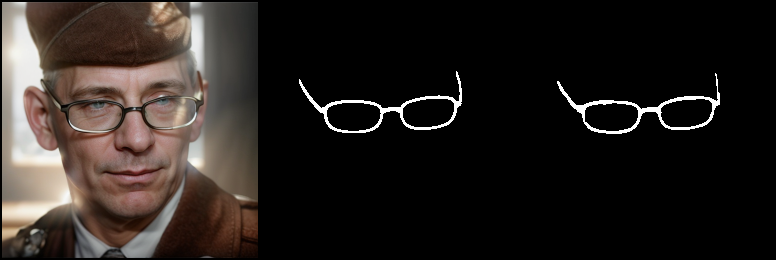

2. Saving predictions only.
  <br>  If you input PATH for masks change argument ```orig_img``` to False at function below <br>
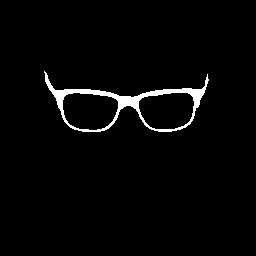

In [13]:
save_predictions_as_images(test_loader, model, device=DEVICE, orig_img=False)

Directory 'saved_images/' created successfully
